# Exercises
- file name: `time_series_anomaly_detection.py` or `time_series_anomaly_detection.ipynb`

The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.

**Hint**: You will need to explore the database and significantly adjust your acquisition step (yay SQL!)

**BONUS:** Identify users who are viewing both the web dev and data science curriculum 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# from matplotlib import style
import seaborn as sns
%matplotlib inline

# pd.plotting.register_matplotlib_converters()
import env

### ACQUIRE

In [2]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
query = '''
SELECT date, time, path, user_id, cohort_id, program_id, ip, name, slack, start_date, end_date, created_at, updated_at
FROM logs
JOIN cohorts on logs.cohort_id = cohorts.id
'''
df = pd.read_sql(query, url)
df.head()

,date,time,path,user_id,cohort_id,program_id,ip,name,slack,start_date,end_date,created_at,updated_at
0,2018-01-26,09:55:03,/,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
1,2018-01-26,09:56:02,java-ii,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,2,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10


### 1. Label students by the program they are in.


In [3]:
df['cohort_id'] = df.cohort_id.astype(int)

1 = php


2 = java


3 = Data Science


4 = Front-End

In [4]:
conditions = [df.program_id == 1, df.program_id == 2, df.program_id == 3, df.program_id == 4]
result = ['web_dev','web_dev','data_science','web_dev']
df['program_name'] = np.select(conditions, result)

In [5]:
df.head()

,date,time,path,user_id,cohort_id,program_id,ip,name,slack,start_date,end_date,created_at,updated_at,program_name
0,2018-01-26,09:55:03,/,1,8,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,web_dev
1,2018-01-26,09:56:02,java-ii,1,8,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,web_dev
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,web_dev
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,web_dev
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,2,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,web_dev


### 2. Is it possible to identify the user_id of a staff member?


In [6]:
df[df.name == 'Staff'].user_id.unique()

array([ 53, 314,  40,  64,  11, 211,   1, 312, 146, 248, 370, 397, 404,
       257, 428, 461,  37, 514, 539, 545, 546, 572, 315,  41, 592, 618,
       620, 521, 652, 502, 653, 480, 738, 742, 745, 813, 430, 816, 581,
       854, 855, 744, 893, 148, 894, 513, 630, 308, 951, 953, 980])

### 3. Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.

In [7]:
df['date'] = pd.to_datetime(df.date)

In [8]:
df = df.set_index(df.date)

In [9]:
df['end_date'] = pd.to_datetime(df.end_date)

In [30]:
df[df.date > df.end_date].user_id.unique().shape

(592,)

### 4. Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2. 

In [11]:
pages = df.path.resample('D').count()

<AxesSubplot:xlabel='date'>

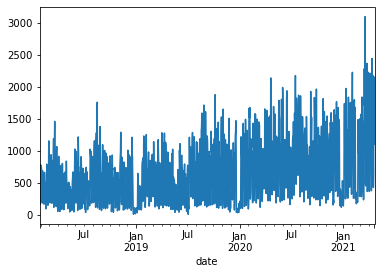

In [12]:
pages.plot()

In [13]:
# set the window span
span = 30

# compute midband
midband = df.path.resample('D').count().ewm(span=span).mean()

midband.head()

date
2018-01-26    533.000000
2018-01-27    376.450000
2018-01-28    302.284709
2018-01-29    434.739290
2018-01-30    475.525441
Freq: D, Name: path, dtype: float64

In [14]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()

stdev.head()

date
2018-01-26           NaN
2018-01-27    214.253355
2018-01-28    192.738756
2018-01-29    292.489456
2018-01-30    262.780177
Freq: D, Name: path, dtype: float64

In [15]:
# compute upper and lower bands
ub = midband + stdev*2
lb = midband - stdev*2
ub

date
2018-01-26            NaN
2018-01-27     804.956709
2018-01-28     687.762221
2018-01-29    1019.718202
2018-01-30    1001.085795
                 ...     
2021-04-17    2797.621100
2021-04-18    2743.915056
2021-04-19    2819.783757
2021-04-20    2839.229086
2021-04-21    2780.075594
Freq: D, Name: path, Length: 1182, dtype: float64

In [16]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,804.956709,-52.056709
2018-01-28,687.762221,-83.192803
2018-01-29,1019.718202,-150.239623
2018-01-30,1001.085795,-50.034912


In [17]:
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,533,533.000000,NaN,NaN
2018-01-27,230,376.450000,804.956709,-52.056709
2018-01-28,168,302.284709,687.762221,-83.192803
2018-01-29,783,434.739290,1019.718202,-150.239623
2018-01-30,614,475.525441,1001.085795,-50.034912


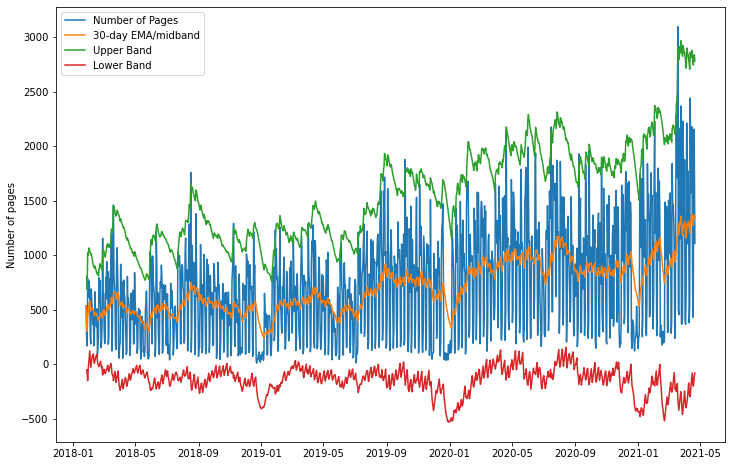

In [18]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [31]:
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])


In [32]:
my_df[my_df.pct_b>1]

,pages,midband,ub,lb,pct_b
date,,,,,
2018-02-27,1156,475.918187,1051.308691,-99.472317,1.090974
2018-03-20,1460,649.891473,1451.666606,-151.883660,1.005197
2018-05-30,1028,375.089886,971.090171,-220.910400,1.047743
2018-07-23,1026,426.685621,997.344326,-143.973083,1.025108
2018-08-17,1760,748.528472,1654.637043,-157.580099,1.058140
2018-11-08,1291,559.032878,1248.528536,-130.462781,1.030799
2019-01-28,1232,446.166837,1165.703309,-273.369635,1.046069
2019-07-08,1212,451.405230,1163.336355,-260.525895,1.034177
2019-10-07,1878,795.149179,1784.161043,-193.862685,1.047441


### 5. Plot the access activity of these students.


<AxesSubplot:xlabel='date'>

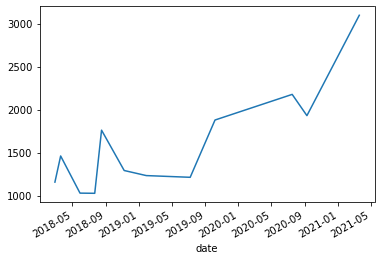

In [34]:
my_df[my_df.pct_b>1].pages.plot()